In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,classification_report,plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

import graphviz
import pydotplus
import matplotlib.pyplot as plt


from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 전처리

In [ ]:
train = pd.read_csv("train.csv")

# 1차 변수 제거 및 타입 변경

# 데이터 셋에 있는 Y, N을 1,0으로 변경
train = train.replace({'Y':1,'N':0})

# 단일 값, 흡연 판별에 불필요한 속성 제거 / ID, 시도코드, 구강검진 수검 여부
train = train.drop(['ID','SIDO','HCHK_OE_INSPEC_YN','WAIST'],axis=1)

#절반 이상이 결측치인 칼럼 드랍 / 총 콜레스테롤, 트리글리세라이드, HDL콜레스테롤, LDL콜레스테롤, 치아우식증 유무, 치석 유무
train = train.drop(['TOT_CHOLE', 'TRIGLYCERIDE',
              'HDL_CHOLE','HDL_CHOLE','LDL_CHOLE',
              'CRS_YN','TTR_YN'],axis=1)

#나이와 높은 상관관계를 가지고, 의사결정변수 나무에서도 크게 중요하지 않았던 청력 제거
train = train.drop(['HEAR_LEFT','HEAR_RIGHT'],axis=1)

#시력 데이터 범주화 / 실명이 아니면 0 실명이면 1
train['SIGHT_LEFT_CATE'] =train['SIGHT_LEFT'] 
train['SIGHT_RIGHT_CATE']= train['SIGHT_RIGHT'] 

train.loc[train['SIGHT_LEFT'] <= 3,'SIGHT_LEFT_CATE']='0' 
train.loc[train['SIGHT_LEFT'] >3, 'SIGHT_LEFT_CATE']='1'
train.loc[train['SIGHT_RIGHT'] <= 3,'SIGHT_RIGHT_CATE']='0'
train.loc[train['SIGHT_RIGHT'] >3, 'SIGHT_RIGHT_CATE']='1'

train= train.astype({'SIGHT_LEFT_CATE':'category','SIGHT_RIGHT_CATE':'category'})

#변수 카테고리화
train= train.astype({'SEX':'category',
                    'SIGHT_LEFT_CATE':'category','SIGHT_RIGHT_CATE':'category',
                    'AGE':'category','HEIGHT':'category', 'WEIGHT': 'category',
                    'OLIG_PROTE':'category', 'DRK_YN':'category'})

# 이상치 제거

#이상치를 결측치로
train.loc[train['HMG'] < 5, 'HMG']=np.NaN
train.loc[train['HMG'] >=20,'HMG']= np.NaN
train.loc[train['BLDS'] >= 250, 'BLDS']=np.NaN
train.loc[train['BP_HIGH'] <= 40,'BP_HIGH']=np.nan
train.loc[train['BP_HIGH'] >= 180,'BP_HIGH']=np.nan
train.loc[train['BP_LWST'] <= 40,'BP_LWST']=np.nan
train.loc[train['BP_LWST'] >= 180,'BP_LWST']=np.nan
train.loc[train['CREATININE'] >= 70, 'CREATININE']=np.nan
train.loc[train['SGOT_AST'] >= 10000, 'SGOT_AST']=np.nan
train.loc[train['SGOT_ALT'] >= 10000, 'SGOT_ALT']=np.nan
train.loc[(train['SEX']==1) & (train['GAMMA_GTP'] >= 550), 'GAMMA_GTP']=np.nan
train.loc[(train['SEX']==2) & (train['GAMMA_GTP'] >= 380), 'GAMMA_GTP']=np.nan

# 결측값 대체

#KNN 이용에 앞서 정규화
scaler=MinMaxScaler()
train= pd.DataFrame(scaler.fit_transform(train), columns= train.columns)

# 인접이웃 3개를 기준으로 결측치 대체
imputer =KNNImputer(n_neighbors=3)
train=pd.DataFrame(imputer.fit_transform(train), columns=train.columns)

# 정규화된 데이터 역 정규화
train= pd.DataFrame(scaler.inverse_transform(train), columns=train.columns)

#정규화를 했다가 다시 역정규화를 해서 상수형으로 됨

# 요단백 범주화 - 0.5 기준으로 새롭게 변경 
train['OLIG_PROTE_CATE'] = 0

train.loc[(train['OLIG_PROTE'] >0) & (train['OLIG_PROTE'] <=1.5),'OLIG_PROTE_CATE']='1'
train.loc[(train['OLIG_PROTE'] >1.5) & (train['OLIG_PROTE'] <=2), 'OLIG_PROTE_CATE']='2'
train.loc[(train['OLIG_PROTE'] >2) & (train['OLIG_PROTE'] <=2.5),'OLIG_PROTE_CATE']='2'
train.loc[(train['OLIG_PROTE'] >2.5) & (train['OLIG_PROTE'] <=3), 'OLIG_PROTE_CATE']='3'
train.loc[(train['OLIG_PROTE']>3) & (train['OLIG_PROTE'] <=3.5),'OLIG_PROTE_CATE']='3'
train.loc[(train['OLIG_PROTE'] >3.5) & (train['OLIG_PROTE'] <=4), 'OLIG_PROTE_CATE']='4'
train.loc[(train['OLIG_PROTE'] >4) & (train['OLIG_PROTE'] <=4.5),'OLIG_PROTE_CATE']='4'
train.loc[(train['OLIG_PROTE'] >4.5) & (train['OLIG_PROTE'] <=5), 'OLIG_PROTE_CATE']='5'
train.loc[(train['OLIG_PROTE'] >5) & (train['OLIG_PROTE'] <=5.5),'OLIG_PROTE_CATE']='5'
train.loc[(train['OLIG_PROTE'] >5.5) & (train['OLIG_PROTE'] <=6.5), 'OLIG_PROTE_CATE']='6'

train = train.drop(['OLIG_PROTE'],axis=1)

#새로 만들었던 가변수들 원래 변수명으로 변경 
train.rename(columns = {'SIGHT_LEFT_CATE':'SIGHT_LEFT','SIGHT_RIGHT_CATE':'SIGHT_RIGHT','OLIG_PROTE_CATE':'OLIG_PROTE'},inplace=True)

# 소수점 제거를 위해 범주형 데이터 int로 변경
train= train.astype({'SEX':'int', 'SMK_STAT': 'int', 'HEIGHT': 'int', 'WEIGHT':'int'})
train= train.astype({'AGE':'int', 'DRK_YN' : 'int','SIGHT_LEFT': 'int', 'SIGHT_RIGHT': 'int'})

# 범주형 데이터로 변환
train= train.astype({'SEX':'category', 'SMK_STAT': 'category', 'HEIGHT': 'category', 'WEIGHT':'category'})
train= train.astype({'AGE':'category', 'DRK_YN': 'category', 'OLIG_PROTE' : 'category'})
train = train.astype({'SIGHT_LEFT': 'category', 'SIGHT_RIGHT': 'category'})


# 모델링

In [33]:
train.drop(train[train['SMK_STAT']==2].index,inplace=True)

X = train.drop(['SMK_STAT'],axis=1)
y = train['SMK_STAT']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

train score 0.8539564240630461
test score 0.8227389965887345
f1 0.6688427760938835


/opt/anaconda3/envs/field/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


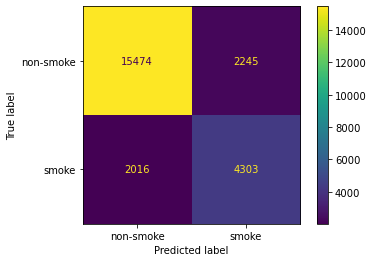

In [34]:
#initial model
clf_model = RandomForestClassifier(max_depth=10,random_state=42)   
clf_model.fit(X_train,y_train.values.ravel())
y_predict = clf_model.predict(X_test)

print('train score', clf_model.score(X_train,y_train))
print('test score', clf_model.score(X_test,y_test))
print('f1',f1_score(y_test,y_predict))

plot_confusion_matrix(clf_model,X_test,y_test,display_labels=['non-smoke','smoke'])

train score 0.9639066506540297
test score 0.9610753502461189
f1 0.015325670498084292


/opt/anaconda3/envs/field/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


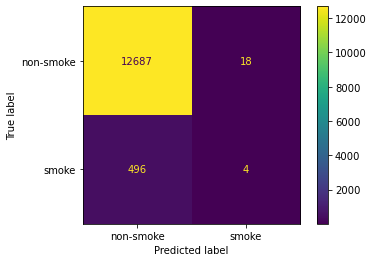

In [39]:
#여성 데이터 트레이닝
X = train[train['SEX']==2].drop(['SMK_STAT'],axis=1)
y = train[train['SEX']==2]['SMK_STAT']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)


over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)

steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

X_smote,y_smote=over.fit_resample(X_train,y_train)
y_smote.value_counts()
clf_model = RandomForestClassifier(max_depth=10,random_state=42)   
clf_model.fit(X_smote,y_smote.values.ravel())
y_predict = clf_model.predict(X_test)

print('train score', clf_model.score(X_train,y_train))
print('test score', clf_model.score(X_test,y_test))
print('f1',f1_score(y_test,y_predict))

plot_confusion_matrix(clf_model,X_test,y_test,display_labels=['non-smoke','smoke'])

train score 0.7330775012857539
test score 0.6633434874919228
f1 0.7057684550221863


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cross val [0.69787561 0.70880038]


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished
/opt/anaconda3/envs/field/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


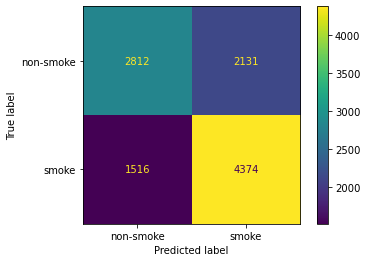

In [40]:
#남성 데이터 트레이닝
X = train[train['SEX']==1].drop(['SMK_STAT'],axis=1)
y = train[train['SEX']==1]['SMK_STAT']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

clf_model = RandomForestClassifier(max_depth=10,random_state=42)   
clf_model.fit(X_train,y_train.values.ravel())
y_predict = clf_model.predict(X_test)

print('train score', clf_model.score(X_train,y_train))
print('test score', clf_model.score(X_test,y_test))
print('f1',f1_score(y_test,y_predict))
print('cross val', cross_val_score(clf_model,X,y.values.ravel(), cv=2, scoring='f1',verbose=1))

plot_confusion_matrix(clf_model,X_test,y_test,display_labels=['non-smoke','smoke'])

Text(0.5, 0, 'Feature Importance')

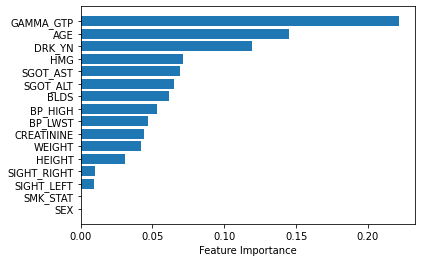

In [41]:
sort = clf_model.feature_importances_.argsort()
plt.barh(train.columns[sort], clf_model.feature_importances_[sort])
plt.xlabel("Feature Importance")

# 최종 답안 도출

In [141]:
test = pd.read_csv("test.csv")
m_ID = test[test['SEX']==1]['ID']
f_ID = test[test['SEX']==2]['ID']

In [142]:
test = test.replace({'Y':1,'N':0})
test = test.drop(['ID','SIDO','HCHK_OE_INSPEC_YN','WAIST'],axis=1)
test = test.drop(['TOT_CHOLE', 'TRIGLYCERIDE',
              'HDL_CHOLE','HDL_CHOLE','LDL_CHOLE',
              'CRS_YN','TTR_YN'],axis=1)
test = test.drop(['HEAR_LEFT','HEAR_RIGHT'],axis=1)

test['SIGHT_LEFT_CATE'] =test['SIGHT_LEFT'] 
test['SIGHT_RIGHT_CATE']= test['SIGHT_RIGHT'] 

test.loc[test['SIGHT_LEFT'] <= 3,'SIGHT_LEFT_CATE']='0' 
test.loc[test['SIGHT_LEFT'] >3, 'SIGHT_LEFT_CATE']='1'
test.loc[test['SIGHT_RIGHT'] <= 3,'SIGHT_RIGHT_CATE']='0'
test.loc[test['SIGHT_RIGHT'] >3, 'SIGHT_RIGHT_CATE']='1'

test= test.astype({'SIGHT_LEFT_CATE':'category','SIGHT_RIGHT_CATE':'category'})

test= test.astype({'SEX':'category',
                    'SIGHT_LEFT_CATE':'category','SIGHT_RIGHT_CATE':'category',
                    'AGE':'category','HEIGHT':'category', 'WEIGHT': 'category',
                    'OLIG_PROTE':'category', 'DRK_YN':'category'})

test.loc[test['HMG'] < 5, 'HMG']=np.NaN
test.loc[test['HMG'] >=20,'HMG']= np.NaN
test.loc[test['BLDS'] >= 250, 'BLDS']=np.NaN
test.loc[test['BP_HIGH'] <= 40,'BP_HIGH']=np.nan
test.loc[test['BP_HIGH'] >= 180,'BP_HIGH']=np.nan
test.loc[test['BP_LWST'] <= 40,'BP_LWST']=np.nan
test.loc[test['BP_LWST'] >= 180,'BP_LWST']=np.nan
test.loc[test['CREATININE'] >= 70, 'CREATININE']=np.nan
test.loc[test['SGOT_AST'] >= 10000, 'SGOT_AST']=np.nan
test.loc[test['SGOT_ALT'] >= 10000, 'SGOT_ALT']=np.nan
test.loc[(test['SEX']==1) & (test['GAMMA_GTP'] >= 550), 'GAMMA_GTP']=np.nan
test.loc[(test['SEX']==2) & (test['GAMMA_GTP'] >= 380), 'GAMMA_GTP']=np.nan

scaler=MinMaxScaler()
test= pd.DataFrame(scaler.fit_transform(test), columns= test.columns)
imputer =KNNImputer(n_neighbors=3)
test=pd.DataFrame(imputer.fit_transform(test), columns=test.columns)
test= pd.DataFrame(scaler.inverse_transform(test), columns=test.columns)

test['OLIG_PROTE_CATE'] = 0

test.loc[(test['OLIG_PROTE'] >0) & (test['OLIG_PROTE'] <=1.5),'OLIG_PROTE_CATE']='1'
test.loc[(test['OLIG_PROTE'] >1.5) & (test['OLIG_PROTE'] <=2), 'OLIG_PROTE_CATE']='2'
test.loc[(test['OLIG_PROTE'] >2) & (test['OLIG_PROTE'] <=2.5),'OLIG_PROTE_CATE']='2'
test.loc[(test['OLIG_PROTE'] >2.5) & (test['OLIG_PROTE'] <=3), 'OLIG_PROTE_CATE']='3'
test.loc[(test['OLIG_PROTE']>3) & (test['OLIG_PROTE'] <=3.5),'OLIG_PROTE_CATE']='3'
test.loc[(test['OLIG_PROTE'] >3.5) & (test['OLIG_PROTE'] <=4), 'OLIG_PROTE_CATE']='4'
test.loc[(test['OLIG_PROTE'] >4) & (test['OLIG_PROTE'] <=4.5),'OLIG_PROTE_CATE']='4'
test.loc[(test['OLIG_PROTE'] >4.5) & (test['OLIG_PROTE'] <=5), 'OLIG_PROTE_CATE']='5'
test.loc[(test['OLIG_PROTE'] >5) & (test['OLIG_PROTE'] <=5.5),'OLIG_PROTE_CATE']='5'
test.loc[(test['OLIG_PROTE'] >5.5) & (test['OLIG_PROTE'] <=6.5), 'OLIG_PROTE_CATE']='6'

test = test.drop('OLIG_PROTE',axis=1)
test.rename(columns = {'SIGHT_LEFT_CATE':'SIGHT_LEFT','SIGHT_RIGHT_CATE':'SIGHT_RIGHT','OLIG_PROTE_CATE':'OLIG_PROTE'},inplace=True)
test= test.astype({'SEX':'int', 'HEIGHT': 'int', 'WEIGHT':'int'})
test= test.astype({'AGE':'int', 'DRK_YN' : 'int','SIGHT_LEFT': 'int', 'SIGHT_RIGHT': 'int'})
test= test.astype({'SEX':'category', 'HEIGHT': 'category', 'WEIGHT':'category'})
test= test.astype({'AGE':'category', 'DRK_YN': 'category', 'OLIG_PROTE' : 'category'})
test = test.astype({'SIGHT_LEFT': 'category', 'SIGHT_RIGHT': 'category'})


In [143]:
#남성 데이터 트레이닝

Xm = train[train['SEX']==1].drop(['SMK_STAT'],axis=1)
ym = train[train['SEX']==1]['SMK_STAT']

clf_model = RandomForestClassifier(max_depth=10,random_state=42)   
clf_model.fit(Xm,ym.values.ravel())

ym_predict = clf_model.predict(test[test['SEX']==1])
id_df = pd.DataFrame({'ID': m_ID, 'Prediction': list(ym_predict)}).explode('ID')

In [172]:
#여성 데이터 트레이닝
Xf = train[train['SEX']==2].drop(['SMK_STAT'],axis=1)
yf = train[train['SEX']==2]['SMK_STAT']

over = RandomOverSampler(sampling_strategy=0.1)
X_smote,y_smote=over.fit_resample(Xf,yf)
clf_model = RandomForestClassifier(max_depth=10,random_state=42)   
clf_model.fit(X_smote,y_smote)

yf_predict = clf_model.predict(test[test['SEX']==2])

In [173]:
id_df2 = pd.DataFrame({'ID': f_ID, 'Prediction': list(yf_predict)}).explode('ID')
final = pd.concat([id_df, id_df2]).sort_values('ID')
final.to_csv("submission.csv",index=False)